# **Predicción del Tráfico Web en Retail de Gran Consumo: *Modelización mediante series temporales SARIMA*.**

En el presente notebook desarrollamos la primera fase del caso de uso: **"Modelización del Tráfico Web y Atribución de Inversión Publicitaria en Retail de Gran Consumo"**. Esta fase se centra en el análisis del tráfico web registrado por una empresa internacional del sector moda y hogar, con el objetivo de **predecir la evolución de los visitantes únicos durante los próximos seis meses**.

La importancia del tráfico web como indicador clave del rendimiento digital en entornos omnicanal justifica el uso de modelos estadísticos avanzados. En este caso, se ha optado por un enfoque de **series temporales (modelo SARIMA)** que nos permitirá identificar patrones de comportamiento, tendencias estacionales y variaciones interanuales.

**Objetivos.**
- Construir un modelo SARIMA que permita predecir el volumen de visitantes únicos a la web.
- Identificar patrones estacionales, tendencias y variaciones anuales.
- Generar una predicción fiable a medio plazo (6 meses) que sirva de base para la toma de decisiones estratégicas.

**Metodología.** Para este análisis se ha elegido un enfoque basado en series temporales, concretamente un modelo SARIMA, ya que:
- Permite modelar componentes de tendencia, estacionalidad y ruido de manera conjunta.
- Es adecuado para datos temporales con patrones repetitivos como los del tráfico web.
- Se puede incorporar variables exógenas como eventos o fines de semana (modelo SARIMAX en caso de ser necesario).

## **Importación de librerías.**

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pyodbc
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import json
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## **Importación e información de Dataframes.**
En este apartado se realizará la carga de las diferentes tablas necesarias para la prediccón del tráfico web en el sector retail del caso de uso. La información proviene de dos posibles fuentes:

1. **Archivos locales (.csv)**: Para agilizar el proceso y evitar conexiones innecesarias a la base de datos, se verificará si los datos ya se encuentran almacenados localmente en la carpeta `../data/raw`. En caso afirmativo, los archivos serán importados directamente desde dicha ruta.

2. **Base de datos Azure SQL**: Si los archivos locales no existen, se establecerá una conexión con la base de datos **usecases** ubicada en el servidor de Azure proporcionado. Las tablas serán consultadas, descargadas y guardadas en la carpeta local para su uso posterior.

Este enfoque permite optimizar el flujo de trabajo, evitando sobrecargar el servidor y asegurando que los datos queden disponibles para futuros análisis sin necesidad de realizar nuevas consultas.

Las tablas utilizadas son: **MMM01-WEB** que contiene información del tráfico web; **MMM04-TIME** que contiene información sobre los datos temporales.

In [183]:
# Configuración de conexión a Azure SQL.
server = os.getenv("SERVER", "")
database = os.getenv("DATABASE", "")
driver = '{ODBC Driver 17 for SQL Server}'
conn_str = f"DRIVER={driver};SERVER={server};DATABASE={database};Authentication=ActiveDirectoryInteractive"

In [184]:
# Rutas locales.
data_path = '../data/raw/'
files = {
    'web': 'MMM01_WEB.csv',
    'time': 'MMM04_TIME.csv',
}

In [185]:
# Función para cargar desde local o Azure.
def load_data(table_key, query):
    file_path = os.path.join(data_path, files[table_key])
    if os.path.exists(file_path):
        print(f'Cargando {files[table_key]} desde local...')
        df = pd.read_csv(file_path)
    else:
        print(f'Archivo {files[table_key]} no encontrado en local. Cargando desde Azure...')
        conn = pyodbc.connect(conn_str)
        df = pd.read_sql(query, conn)
        df.to_csv(file_path, index=False)
        print(f'Guardado en {file_path}')
    return df

In [186]:
# Cargar tablas.
df_web = load_data('web', "SELECT * FROM DATAEX.MMM01_WEB")
df_time = load_data('time', "SELECT * FROM DATAEX.MMM04_TIME")

# Unir por ID_date.
df = pd.merge(df_web, df_time, on='ID_Date', how='inner')

Cargando MMM01_WEB.csv desde local...
Cargando MMM04_TIME.csv desde local...


## **Revisión y limpieza de los datos.**
Antes de llevar a cabo el análisis, se realizó una revisión y limpieza de los datos con el fin de asegurar su calidad y coherencia. Cabe destacar que en un análisis exploratorio previo se verificó que **no existían valores nulos ni registros duplicados** en las tablas utilizadas.

- Comprobar la estructura y el formato de los datos.
- Identificar y gestionar posibles valores nulos o duplicados.
- Asegurar que los tipos de datos sean correctos (fechas, numéricos, categóricos).
- Homogeneizar las variables clave, como las fechas, para facilitar la unión entre tablas.
- Detectar y corregir posibles inconsistencias que puedan afectar al análisis posterior.

In [187]:
df.head()

,ID_Date,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch,Dias_mes,Dia_inicio_mes,Dia_findemes,working_days,Dias_fines_semana,Easterweek
0,202201,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798,31,5,7,21,10,0
1,202202,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656,28,1,7,20,8,0
2,202203,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243,31,1,3,23,8,0
3,202204,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510,30,4,5,22,8,1
4,202205,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031,31,6,1,21,10,0


In [188]:
df.describe()

,ID_Date,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch,Dias_mes,Dia_inicio_mes,Dia_findemes,working_days,Dias_fines_semana,Easterweek
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,202306.500000,255653.500000,12436.583333,43186.750000,83643.416667,4597.194444,84491.861111,2348.722222,160406.388889,31749.750000,33469.388889,25583.916667,30.416667,3.888889,4.027778,21.722222,8.694444,0.083333
std,82.881844,42557.597755,3980.028646,5958.272916,10828.599868,6651.756738,24628.745582,3224.130878,16720.484708,37057.134827,8482.501478,17150.656759,0.874234,1.967998,2.006932,0.944491,0.821825,0.280306
min,202201.000000,195193.000000,3711.000000,33190.000000,61335.000000,546.000000,50402.000000,14.000000,130510.000000,405.000000,18959.000000,11347.000000,28.000000,1.000000,1.000000,20.000000,8.000000,0.000000
25%,202209.750000,229823.000000,10652.000000,38843.000000,75030.500000,1528.250000,66469.500000,112.750000,146709.250000,9063.750000,24920.500000,18089.250000,30.000000,2.000000,2.000000,21.000000,8.000000,0.000000
50%,202306.500000,252340.500000,12825.000000,43055.000000,83524.500000,2062.500000,77956.500000,911.000000,159079.000000,17145.500000,35473.000000,19661.000000,31.000000,4.000000,4.000000,22.000000,8.000000,0.000000
75%,202403.250000,267961.500000,15371.000000,46639.500000,90698.250000,5219.000000,105937.000000,3356.500000,173118.000000,37912.500000,40658.250000,28731.750000,31.000000,5.250000,6.000000,22.000000,9.000000,0.000000
max,202412.000000,396642.000000,19444.000000,59157.000000,109531.000000,35521.000000,145599.000000,10793.000000,203699.000000,162588.000000,45763.000000,110054.000000,31.000000,7.000000,7.000000,23.000000,10.000000,1.000000


In [189]:
df.shape

(36, 18)

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   ID_Date                       36 non-null     int64
 1   Unique_visitors               36 non-null     int64
 2   PDFBrochuresDownloaded        36 non-null     int64
 3   ProductConfigurator           36 non-null     int64
 4   Product_configurator_Visists  36 non-null     int64
 5   SocialNetworks                36 non-null     int64
 6   DirectTraffic                 36 non-null     int64
 7   EMail                         36 non-null     int64
 8   NaturalSearch                 36 non-null     int64
 9   OnlineMedia                   36 non-null     int64
 10  OtherReferrer                 36 non-null     int64
 11  PaidSearch                    36 non-null     int64
 12  Dias_mes                      36 non-null     int64
 13  Dia_inicio_mes                36 non-

Los datos serán transformados en una serie temporal con índice de fecha (`ID_Date`), asegurando su formato adecuado para el modelado posterior. También se validará la granularidad de la serie y se preparará el subconjunto relevante para el análisis.

In [191]:
# Convertir fechas de formato YYYYMM a fecha con día 1 del mes.
df['ID_Date'] = pd.to_datetime(df['ID_Date'].astype(str), format='%Y%m')

# Establecer la columna de fecha como índice.
df.set_index('ID_Date', inplace=True)

# Frecuencia mensual.
df.index.freq = 'MS'

In [192]:
df.head()

,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch,Dias_mes,Dia_inicio_mes,Dia_findemes,working_days,Dias_fines_semana,Easterweek
ID_Date,,,,,,,,,,,,,,,,,
2022-01-01,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798,31,5,7,21,10,0
2022-02-01,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656,28,1,7,20,8,0
2022-03-01,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243,31,1,3,23,8,0
2022-04-01,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510,30,4,5,22,8,1
2022-05-01,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031,31,6,1,21,10,0


### **Visualización de la serie temporal: Unique Visitors.**
Como primer paso en el análisis del tráfico web, se procede a la visualización de la serie temporal correspondiente al número de visitantes únicos registrados en el sitio web. Esta variable representa la **métrica principal de interés** en el contexto del objetivo de predicción, ya que refleja la evolución del interés y la interacción de los usuarios con la plataforma digital de la empresa.

La representación gráfica de esta serie permite **identificar visualmente patrones** relevantes como tendencias a largo plazo, estacionalidades recurrentes y posibles anomalías o cambios estructurales en el comportamiento del tráfico. Este análisis exploratorio es fundamental para justificar la idoneidad del enfoque basado en modelos de series temporales y, en particular, para evaluar la aplicabilidad de un modelo SARIMA.

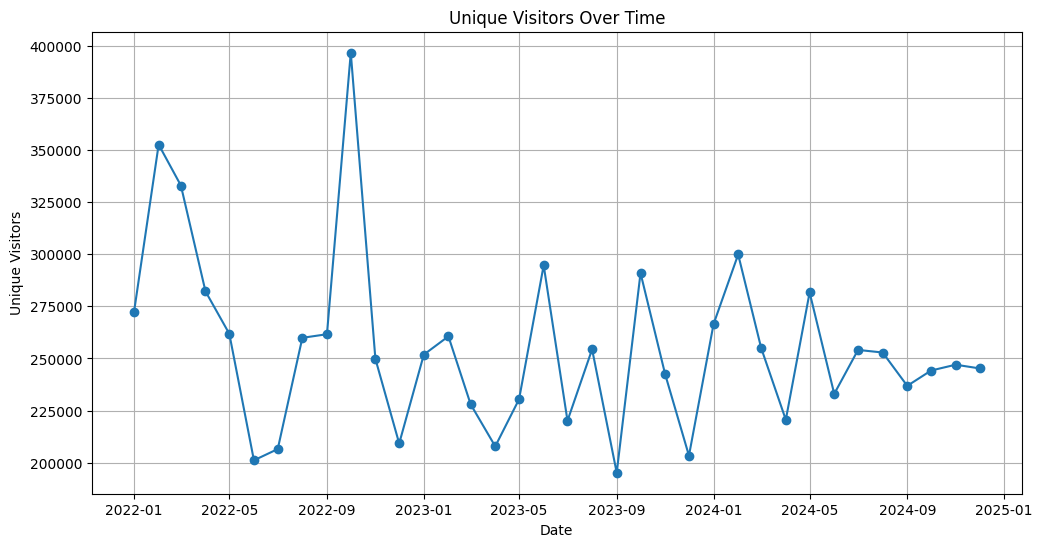

In [193]:
# Graficar la serie temporal de visitantes únicos.
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Unique_visitors'], marker='o', linestyle='-')
plt.title('Unique Visitors Over Time')
plt.xlabel('Date')
plt.ylabel('Unique Visitors')
plt.grid(True)
plt.show()

La serie de visitantes únicos muestra una **no muy clara estacionalidad** con picos recurrentes y una **ligera tendencia decreciente** en el largo plazo. A partir de 2023, el comportamiento se vuelve **más estable y cíclico**, lo que sugiere que un modelo SARIMA es adecuado para capturar tanto la estacionalidad como la tendencia.

## **Preprocesamiento para modelado SARIMA.**
Antes de ajustar el modelo de series temporales, es necesario dividir los datos en dos conjuntos:
- **Entrenamiento (train)**: utilizado para ajustar el modelo.
- **Prueba (test)**: reservado para validar la capacidad predictiva sobre datos no vistos.

Una vez realizada esta división, se utilizará la función `auto_arima` para estimar automáticamente los hiperparámetros óptimos del modelo **SARIMA**, tanto en su componente regular (p, d, q) como estacional (P, D, Q, s). Esta función evalúa múltiples combinaciones posibles y selecciona la mejor configuración basada en criterios estadísticos como el AIC.

In [194]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba (80% entrenamiento, 20% prueba).
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

### **Búsqueda automática de hiperparámetros para el modelo SARIMA.**
El modelo SARIMA se define por siete hiperparámetros que deben ser cuidadosamente seleccionados para garantizar un buen ajuste:
- **p**: número de retardos (lags) autoregresivos (AR)
- **d**: grado de diferenciación no estacional
- **q**: número de términos de media móvil (MA)
- **P**: número de retardos autoregresivos estacionales
- **D**: grado de diferenciación estacional
- **Q**: número de términos de media móvil estacional
- **s**: periodicidad estacional (en este caso, `s=12` porque los datos son mensuales)

Dado que probar todas las combinaciones posibles puede ser muy costoso computacionalmente, utilizaremos la función `auto_arima`, que evalúa automáticamente múltiples configuraciones posibles y selecciona la que minimiza el **AIC (Akaike Information Criterion)**.

#### **Estimación de los parámetros.**
Para controlar el proceso de búsqueda, debemos definir rangos razonables para los hiperparámetros:
- **d y D**: se determinarán automáticamente según la estacionariedad de la serie.
- **s**: Se fija en 12, ya que los datos son mensuales y se espera una estacionalidad anual
- **p, q, P, Q**: Una vez que la serie ha sido correctamente diferenciada, se visualizan las funciones:
   - **PACF (Partial Autocorrelation)** para estimar `p`: cuántos lags pasados afectan directamente.
   - **ACF (Autocorrelation)** para estimar `q`: cuántos errores pasados afectan la predicción.

   Se consideran como candidatos los lags donde las barras sobresalen significativamente del intervalo de confianza (±1.96/√n).

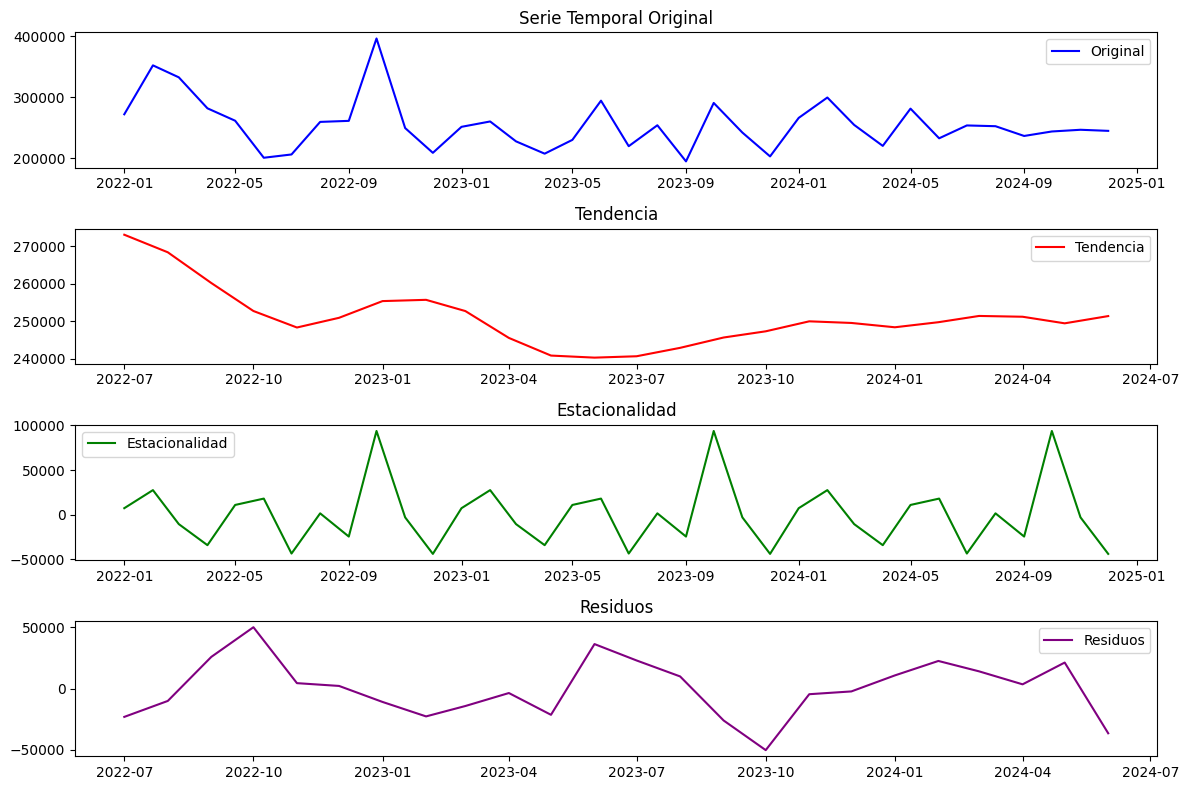

In [195]:
# Descomposición de la serie temporal.
decomposition = seasonal_decompose(df['Unique_visitors'], model='additive', period=12)

# Obtención de las componentes.
## Tendencia: Parte de la serie temporal que muestra la dirección general a largo plazo (aumento o disminución).
## Estacionalidad: Parte de la serie temporal que se repite en intervalos regulares (por ejemplo, mensual, trimestral, etc.).
## Residuos: Parte aleatoria de la serie temporal que no se puede explicar por la tendencia o la estacionalidad.
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Graficar las componentes.
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df.index, df['Unique_visitors'], label='Original', color='blue')
plt.legend()
plt.title('Serie Temporal Original')

plt.subplot(412)
plt.plot(trend.index, trend, label='Tendencia', color='red')
plt.legend()
plt.title('Tendencia')

plt.subplot(413)
plt.plot(seasonal.index, seasonal, label='Estacionalidad', color='green')
plt.legend()
plt.title('Estacionalidad')

plt.subplot(414)
plt.plot(residuals.index, residuals, label='Residuos', color='purple')
plt.legend()
plt.title('Residuos')

plt.tight_layout()
plt.show()

La **visualización** sugiere que no es estacionaria: se observan patrones de **estacionalidad clara** y una **ligera tendencia descendente** en los primeros periodos. Además de que el test para menos de 50 datos, **puede ser inestable**. Por tanto en base a la visualización, vamos a concluir lo siguiente: `d=1` y `D=1`.

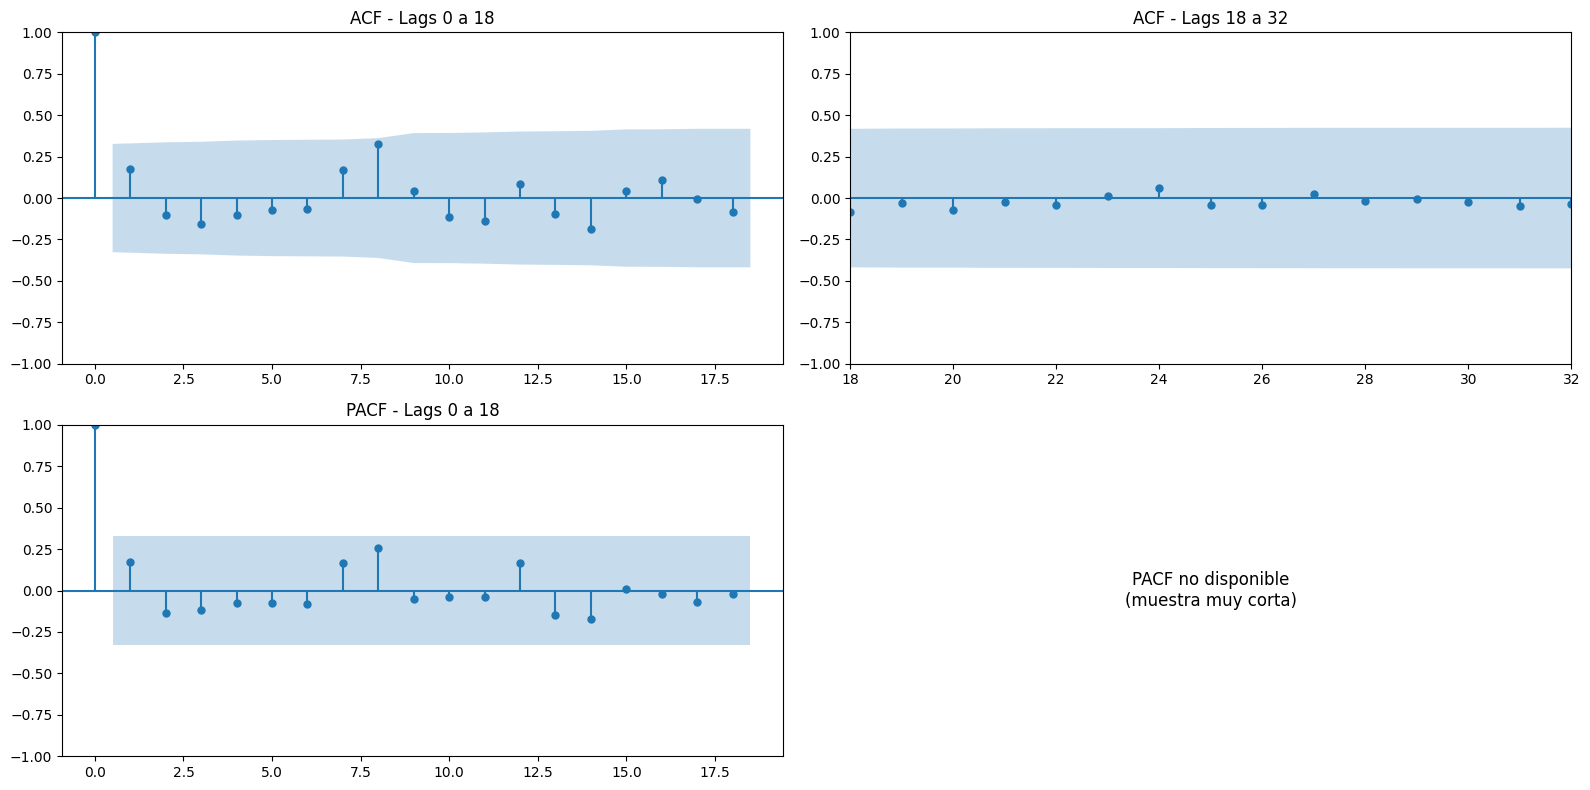

In [196]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# ACF - 0 a 18.
plot_acf(df['Unique_visitors'], lags=18, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Lags 0 a 18')

# ACF - 18 a 32.
plot_acf(df['Unique_visitors'], lags=32, ax=axes[0, 1])
axes[0, 1].set_title('ACF - Lags 18 a 32')
axes[0, 1].set_xlim(18, 32)

# PACF - 0 a 18.
plot_pacf(df['Unique_visitors'], lags=18, ax=axes[1, 0], method='ywm')
axes[1, 0].set_title('PACF - Lags 0 a 18')

# PACF - 18 a 32.
axes[1, 1].axis('off')
axes[1, 1].text(0.5, 0.5, 'PACF no disponible\n(muestra muy corta)',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=12)

plt.tight_layout()
plt.show()

**Interpretación de ACF y PACF.** El análisis de la **Función de Autocorrelación (ACF)** y la **Función de Autocorrelación Parcial (PACF)** permite identificar el orden de los componentes autorregresivo (`p`) y de media móvil (`q`) en un modelo SARIMA. En este enfoque:

- El **corte en la PACF** (es decir, donde los valores dejan de ser significativamente diferentes de cero) sugiere el orden **`p`** del componente autorregresivo (AR).
- El **corte en la ACF** indica el orden **`q`** del componente de media móvil (MA).

En el gráfico observado, tanto la ACF como la PACF muestran valores significativos no solo en los primeros rezagos, sino también en el **rezago 8**, lo que podría indicar relaciones de dependencia más allá del corto plazo. Esta señal justifica ampliar el rango de búsqueda de parámetros en el modelado, permitiendo probar valores de `p` y `q` mayores, por ejemplo, hasta 3 o 4. En consecuencia, se recomienda ajustar el parámetro `max_order` durante la búsqueda de hiperparámetros para que incluya estos posibles efectos de medio plazo.

#### **Selección automática del modelo SARIMA.**
Una vez estimados los valores más probables para los parámetros `d` y `D`, y analizados los posibles rangos de `p`, `q`, `P` y `Q` mediante ACF y PACF, se procede a realizar una búsqueda automática del modelo SARIMA óptimo.

Para ello se utiliza la función `auto_arima`, que evalúa múltiples combinaciones de hiperparámetros y selecciona aquella que minimiza el **AIC (Akaike Information Criterion)**, garantizando así un equilibrio entre ajuste y complejidad del modelo.

En esta búsqueda se establecen límites definidos para los hiperparámetros (según el análisis previo), lo que permite reducir significativamente el tiempo de cómputo sin sacrificar precisión. Además, se mantiene activado el componente estacional (`seasonal=True`) con una periodicidad mensual (`m=12`), de acuerdo con la naturaleza de los datos.

El modelo resultante será utilizado posteriormente para generar las predicciones del tráfico web.

In [197]:
df[["Unique_visitors", "working_days", "Dias_fines_semana", "Easterweek"]].corr()

,Unique_visitors,working_days,Dias_fines_semana,Easterweek
Unique_visitors,1.000000,-0.207593,0.040195,-0.135022
working_days,-0.207593,1.000000,-0.517372,-0.233827
Dias_fines_semana,0.040195,-0.517372,1.000000,0.113692
Easterweek,-0.135022,-0.233827,0.113692,1.000000


In [198]:
seasonal_periods = 12  # Periodicidad estacional (12 meses para datos mensuales).
serie_temporal = df['Unique_visitors']

# Definir el rango de hiperparámetros para la búsqueda automática.
d, D = 1, 1

## ACF y PACF.
start_p, max_p = 0, 4
start_q, max_q = 0, 2
start_P, max_P = 0, 2
start_Q, max_Q = 0, 2

# Busqueda exhaustiva de hiperparámetros.
model = auto_arima(serie_temporal, seasonal=True, m=seasonal_periods, start_p=start_p, d=d, start_q=start_q,
                    start_P=start_P, D=D, start_Q=start_Q, max_p=max_p, max_q=max_q, max_P=max_P, max_Q=max_Q,
                    stepwise=False, trace=True, error_action='ignore', suppress_warnings=True, scoring='mae')
print("Mejores hiperparámetros SARIMA:", model.get_params())

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=576.683, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=566.236, Time=0.06 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=567.779, Time=0.07 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=569.625, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=568.221, Time=0.05 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=569.503, Time=0.14 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=566.919, Time=0.06 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=568.326, Time=0.10 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=569.767, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=575.776, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=567.595, Time=0.04 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=569.569, Time=0.11 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=571.231, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=569.581, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=571.389, Time=0.26 sec
 ARIMA(0,1

In [199]:
# Guardar los mejores parámetros.
best_params = {
    "order": (1, 1, 0),                      # (p,d,q)
    "seasonal_order": (0, 1, 1, 12),    # (P,D,Q,12)
    "seasonal_periods": 12                     # Frecuencia estacional
}
with open("../model/SARIMA_model.json", "w") as f:
    json.dump(best_params, f)

## **Entrenamiento, evaluación y análisis del modelo SARIMA seleccionado.**
En esta sección se ajusta manualmente un modelo SARIMA con los parámetros obtenidos en el paso anterior. Se evalúa su rendimiento en el conjunto de prueba utilizando métricas estadísticas, se visualizan las predicciones comparadas con los datos reales, y se analiza el comportamiento de los residuos para validar la calidad del modelo.

1. **Entrenamiento del modelo SARIMA**: Se entrena un modelo `SARIMA(p, d, q)(P, D, Q, 12)` sobre los datos de entrenamiento. Ese modelo es el elegido por el `auto_arima`.
2. **Predicción y evaluación**: Se realizan predicciones sobre el conjunto de prueba y se calculan métricas como MAE, RMSE y R².
3. **Visualización**: Se comparan gráficamente las predicciones con los datos reales, así como los residuos.
4. **Análisis de residuos**: Se analiza la distribución de los errores residuales para evaluar la calidad del ajuste.

In [200]:
with open("../model/SARIMA_model.json", "r") as f:
    params = json.load(f)

sarima_model = SARIMAX(
    train['Unique_visitors'],
    order=tuple(params["order"]),
    seasonal_order=tuple(params["seasonal_order"])
    )
sarima_fit = sarima_model.fit()

In [201]:
sarima_predict = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, type='levels')
# Calcular métricas de validación para cada modelo.
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Calcular las métricas para cada modelo.
sarima_metrics2 = calcular_metricas(test['Unique_visitors'], sarima_predict)
print('Métricas SARIMA:')
print('- MSE:', sarima_metrics2[0])
print('- MAE:', sarima_metrics2[1])
print('- RMSE:', sarima_metrics2[2])
print('- R2:', sarima_metrics2[3])

Métricas SARIMA:
- MSE: 1517498359.2616272
- MAE: 34466.63309383397
- RMSE: 38955.081302207895
- R2: -6.833939690969743


**Limitaciones del modelo SARIMA con pocos datos.** Debido al tamaño limitado de la serie temporal (36 observaciones mensuales), el modelo SARIMA presenta limitaciones inherentes. La escasez de ciclos estacionales completos impide una estimación robusta de los componentes estacionales, como confirma el warning generado por `statsmodels`. Esto repercute en la calidad del ajuste y explica métricas de validación poco satisfactorias (e.g., R² negativo). A pesar de ello, el modelo cumple con el objetivo de generar un forecast estructurado, que será empleado en fases posteriores del caso de uso. Se recomienda reevaluar el modelo con más datos históricos en futuras iteraciones.

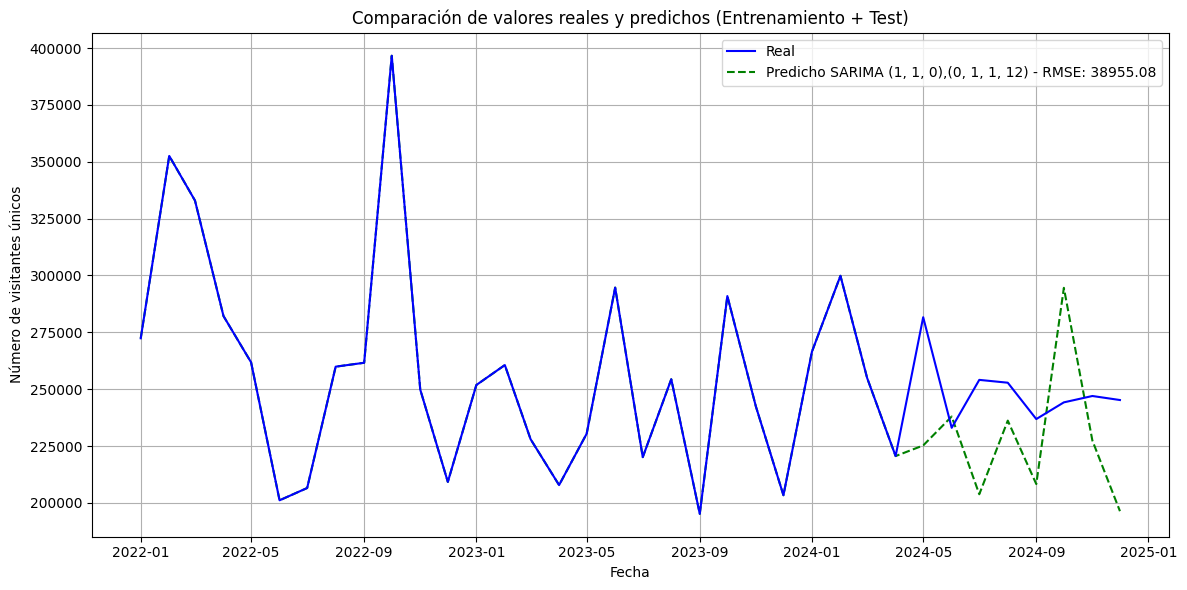

In [202]:
import matplotlib.pyplot as plt

# Unir las series para que el gráfico quede continuo
full_real = pd.concat([train['Unique_visitors'], test['Unique_visitors']])
full_pred = pd.concat([train['Unique_visitors'], sarima_predict])

plt.figure(figsize=(12, 6))

# Línea real completa (entrenamiento + test)
plt.plot(full_real.index, full_real.values, label='Real', color='blue', zorder=3)

# Línea predicha completa (entrenamiento + predicción)
plt.plot(full_pred.index, full_pred.values,
            label=f'Predicho SARIMA {tuple(params["order"])},{tuple(params["seasonal_order"])} - RMSE: {sarima_metrics2[2]:.2f}',
            color='green', linestyle='--')

plt.xlabel('Fecha')
plt.ylabel('Número de visitantes únicos')
plt.title('Comparación de valores reales y predichos (Entrenamiento + Test)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo SARIMA con estos parámetros **capta de forma general la tendencia y nivel** de la serie, pero **no es capaz de adaptarse con precisión a las oscilaciones mensuales rápidas** debido a:
- La **alta variabilidad** de la serie en pocos puntos,
- Y la **limitación del tamaño de muestra** (solo 36 observaciones).

Por tanto, **sí cumple su función de generar una previsión estructurada**, pero **las predicciones deben interpretarse con precaución** y preferiblemente complementarse con modelos adicionales o más datos históricos.

In [203]:
# Imprimir AIC y BIC.
print("ARIMA - AIC:", sarima_fit.aic, "BIC:", sarima_fit.bic)
print("SARIMA - AIC:", sarima_fit.aic, "BIC:", sarima_fit.bic)
# Imprimir coeficientes.
print(f"\nCoeficientes SARIMA {tuple(params['order'])},{tuple(params['seasonal_order'])}:")
print(sarima_fit.summary())

ARIMA - AIC: 369.99577898196503 BIC: 372.1199295852717
SARIMA - AIC: 369.99577898196503 BIC: 372.1199295852717

Coeficientes SARIMA (1, 1, 0),(0, 1, 1, 12):
                                      SARIMAX Results                                       
Dep. Variable:                      Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -181.998
Date:                              Mon, 21 Apr 2025   AIC                            369.996
Time:                                      18:52:06   BIC                            372.120
Sample:                                  01-01-2022   HQIC                           369.973
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------

El modelo SARIMA desarrollado para estimar el tráfico web logra **capturar de forma general la tendencia y los patrones estacionales de la serie temporal**. A pesar de que algunos coeficientes no resultan estadísticamente significativos, el modelo **permite representar el comportamiento cíclico esperado en este tipo de datos mensuales.**

Durante la validación, se observa que el modelo no consigue ajustarse con precisión a las variaciones abruptas presentes en el periodo de test. Esto es coherente con la naturaleza altamente variable del tráfico web y con las limitaciones impuestas por el volumen de datos disponible.

La serie temporal utilizada es relativamente corta, lo que condiciona la robustez del modelo y dificulta una estimación fiable de los componentes estacionales. Este contexto también afecta la calidad del ajuste y la capacidad de generalización del modelo en el corto plazo.

Aun así, el modelo cumple con su propósito dentro del flujo de trabajo: **generar una previsión estructurada y reproducible del tráfico web, que podrá ser utilizada como variable de entrada en los modelos de visitas físicas a tienda y ventas. Para futuras versiones, se recomienda ampliar la serie histórica y complementar el modelo con enfoques adicionales que puedan mejorar la precisión predictiva.**

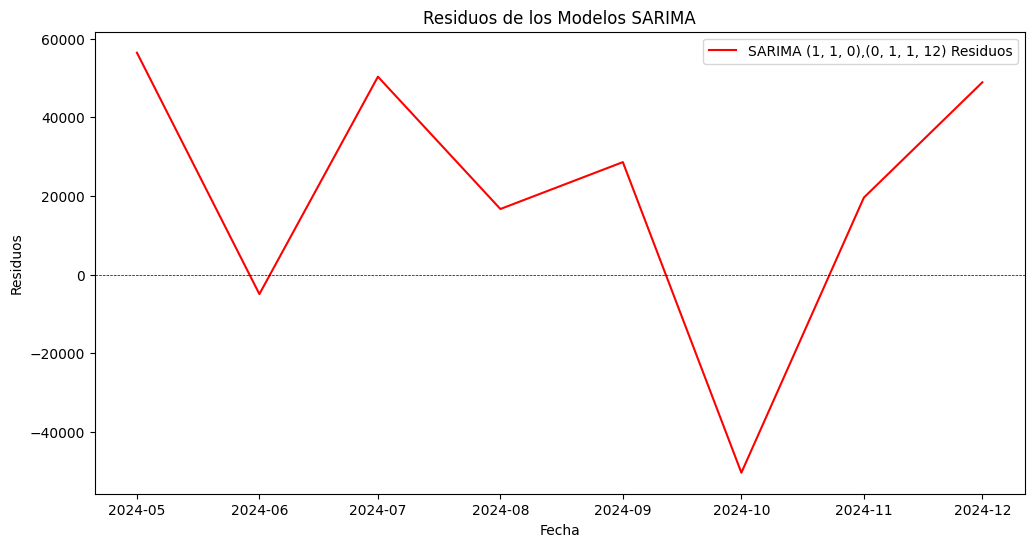

In [204]:
# Análisis de errores: Residuos de cada modelo.
## Los residuos son la diferencia entre los valores reales y los valores predichos por el modelo.
## Un buen modelo tendrá residuos que se distribuyen normalmente alrededor de 0.
sarima_residuals2 = test['Unique_visitors'] - sarima_predict
## Graficar los residuos.
plt.figure(figsize=(12, 6))
plt.plot(test.index, sarima_residuals2, label=f"SARIMA {tuple(params['order'])},{tuple(params['seasonal_order'])} Residuos", color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos de los Modelos SARIMA')
plt.legend()
plt.show()

El comportamiento de los residuos durante el periodo de test muestra que el modelo SARIMA no logra capturar completamente la dinámica del tráfico web. **Aunque el modelo consigue mantener las predicciones dentro de un rango razonable, la presencia de oscilaciones y errores sistemáticos indica que podrían existir patrones no modelados correctamente.** Este análisis refuerza la idea de que sería beneficioso **ampliar la serie temporal** o explorar modelos complementarios que integren más información contextual o variables externas.

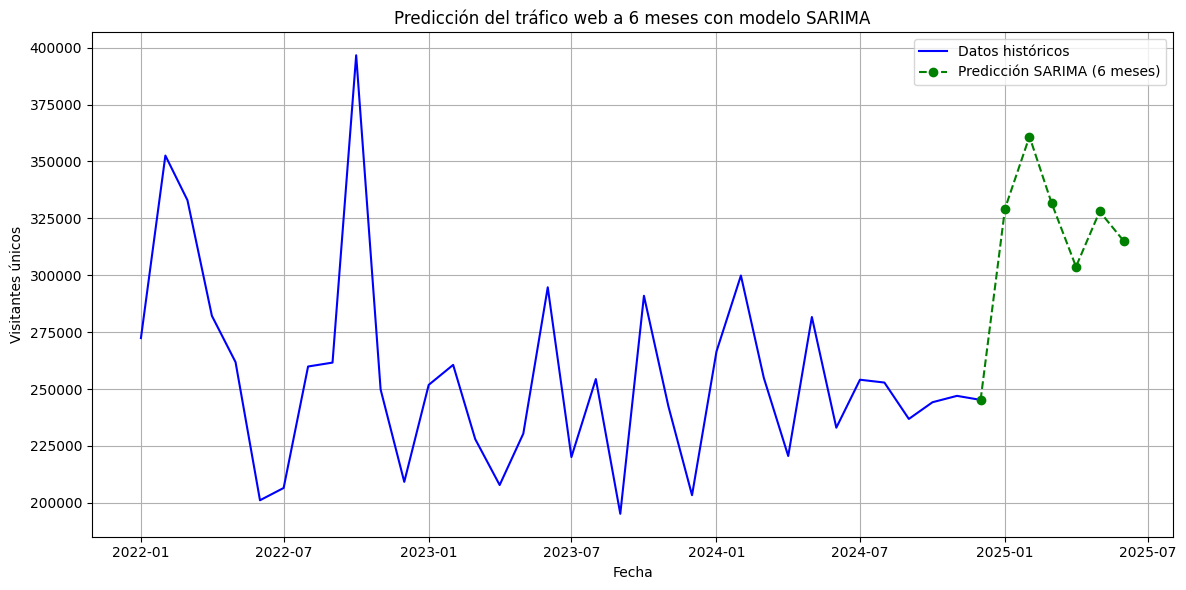

In [205]:
# Ajustar el modelo SARIMA a todos los datos disponibles
sarima_model = SARIMAX(
    df['Unique_visitors'],
    order=tuple(params["order"]),
    seasonal_order=tuple(params["seasonal_order"])
)
sarima_fit = sarima_model.fit()

# Definir el rango de fechas para los próximos 6 meses
start_date = df.index[-1] + pd.DateOffset(months=1)
end_date = start_date + pd.DateOffset(months=5)  # Total: 6 meses

# Generar predicción
sarima_forecast_6months = sarima_fit.predict(start=start_date, end=end_date, typ='levels')
sarima_forecast_6months.index = pd.date_range(start=start_date, periods=6, freq='MS')

# Añadir el último dato real para que la línea quede continua
last_real_value = df['Unique_visitors'].iloc[-1]
last_real_date = df.index[-1]
forecast_with_start = pd.concat([
    pd.Series([last_real_value], index=[last_real_date]),
    sarima_forecast_6months
])

# Graficar datos históricos + predicción conectada
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Unique_visitors'], label='Datos históricos', color='blue')
plt.plot(forecast_with_start.index, forecast_with_start.values, 
        label='Predicción SARIMA (6 meses)', color='green', linestyle='--', marker='o')

plt.xlabel('Fecha')
plt.ylabel('Visitantes únicos')
plt.title('Predicción del tráfico web a 6 meses con modelo SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


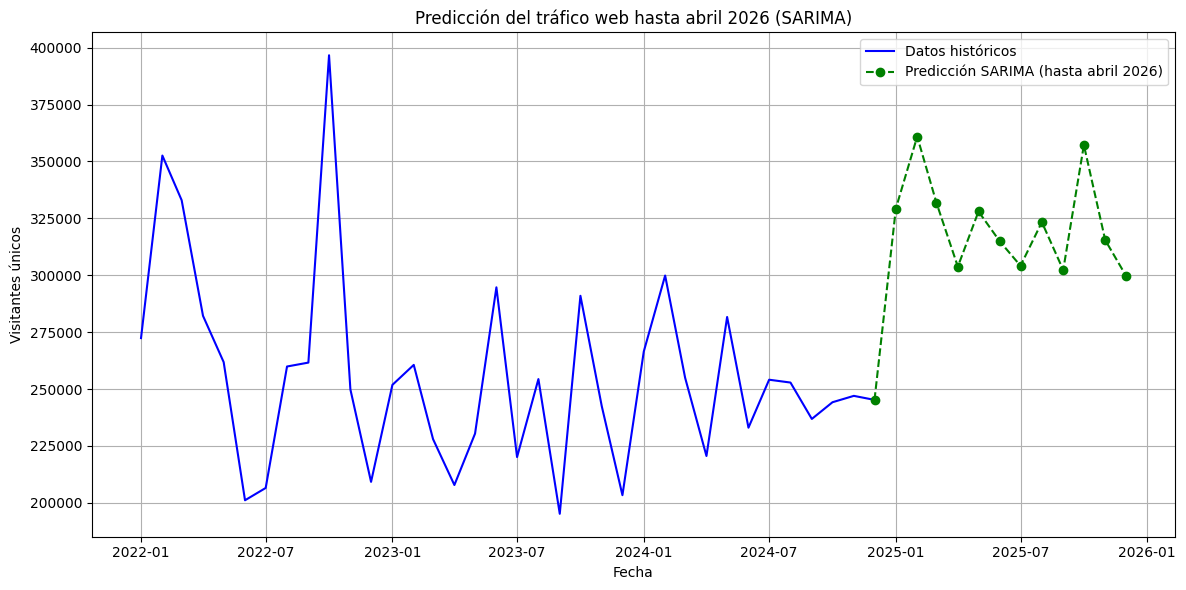

In [206]:
# Ajustar modelo SARIMA a todos los datos disponibles.
sarima_model = SARIMAX(
    df['Unique_visitors'],
    order=tuple(params["order"]),
    seasonal_order=tuple(params["seasonal_order"])
)
sarima_fit = sarima_model.fit()

# Generar predicción mensual hasta abril 2026.
n_steps = 12
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=n_steps, freq='MS')

# Obtener predicciones e intervalos
forecast_obj = sarima_fit.get_forecast(steps=n_steps)
forecast_values = forecast_obj.predicted_mean
forecast_values.index = forecast_index

# Unir el último punto real para que la línea sea continua
last_real = pd.Series([df['Unique_visitors'].iloc[-1]], index=[df.index[-1]])
forecast_with_start = pd.concat([last_real, forecast_values])

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Unique_visitors'], label='Datos históricos', color='blue')
plt.plot(forecast_with_start.index, forecast_with_start.values,
        label='Predicción SARIMA (hasta abril 2026)', color='green', linestyle='--', marker='o')
plt.xlabel('Fecha')
plt.ylabel('Visitantes únicos')
plt.title('Predicción del tráfico web hasta abril 2026 (SARIMA)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Transición al Objetivo 2: Atribución de Visitas Físicas y Ventas.**
A partir de la predicción del tráfico web generada con el modelo SARIMA en el Objetivo 1, se dispone ahora de una estimación mensual de visitantes únicos durante los próximos seis meses. Esta proyección será utilizada como input clave en la primera etapa del Objetivo 2: el modelo de visitas físicas a tienda.

El enfoque planteado establece una cadena causal que conecta la inversión publicitaria con el tráfico web, el tráfico físico y, finalmente, con las ventas. De este modo, el modelo de atribución en dos fases busca explicar:

1. **Cómo influye la inversión publicitaria y el tráfico digital en las visitas físicas a tienda.**
2. **Cómo esas visitas físicas se traducen en ventas, considerando factores temporales y estacionales.**

Este enfoque no solo permite cuantificar el impacto de cada canal de marketing, sino también simular distintos escenarios de inversión futura para optimizar el presupuesto disponible. A continuación, se construirá un modelo de regresión múltiple para estimar el tráfico físico (`Visit Store`) a partir de la inversión por canal y el tráfico web previsto.